In [14]:
import pandas as pd
import os
# change working directory
os.chdir('../')

import logging

logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )
# enable auto reloading of source files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from src.models.grn_classifier import load_grns

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# check if gpu is available
import torch
torch.cuda.is_available()

True

In [4]:
# specify input data directory and load GRNs
grn_dir = 'data/grn_test/b_1'
labels, grns = load_grns(grn_dir)

In [5]:
from src.models.grn_classifier import GRNDataset, GRNDataModule, GRNClassifierModule
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np

# Setup parameters and train model
# skip gene expression for now, will be integrated by vae anyways
expression_data = None

# Create dataset
logging.info(f'Creating dataset with {len(grns)} GRNs')
dataset = GRNDataset(grns, labels, expression_data)

2024-12-05 21:10:40,679 - INFO - Creating dataset with 297 GRNs
2024-12-05 21:10:40,681 - INFO - Computing metrics for GRNs
Processing GRNs: 100%|██████████| 297/297 [02:41<00:00,  1.84grn/s]


In [15]:
# define hyper parameters for model training

max_epochs = 42
batch_size = 32

# Create data module
data_module = GRNDataModule(dataset, batch_size=batch_size, train_val_split=0.8, num_workers=10)

# Calculate number of features
num_features = dataset[0].x.shape[1]
num_classes = len(np.unique(labels))

### 1. VAE approach

In [18]:
from src.models.GVAE import GraphVAE
import pytorch_lightning as pl

model = GraphVAE(
    input_dim=num_features,          # Number of features per node
    num_classes=num_classes,
    hidden_dim=128,                   # Size of hidden layers
    latent_dim=64,                   # Size of latent space
    lr=1e-3,
    kl_weight=0.5,
    node_weight=0,
    edge_weight=0.5,
    dropout_rate=0
)

# Create callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(monitor='val_loss')
]

# Create trainer
trainer = pl.Trainer(
    max_epochs=max_epochs,
    callbacks=callbacks,
    accelerator='auto',
    devices=1,
    gradient_clip_val=1.0,
    logger=pl.loggers.TensorBoardLogger('logs/vae'),
)

2024-12-05 21:45:07,846 - INFO - GPU available: True (cuda), used: True
2024-12-05 21:45:07,847 - INFO - TPU available: False, using: 0 TPU cores
2024-12-05 21:45:07,848 - INFO - HPU available: False, using: 0 HPUs


In [265]:
%reload_ext tensorboard
%tensorboard --logdir logs/vae

In [19]:
trainer.fit(model, data_module)

2024-12-05 21:45:14,801 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2024-12-05 21:45:14,807 - INFO - 
   | Name            | Type               | Params | Mode 
----------------------------------------------------------------
0  | encoder         | Sequential         | 17.5 K | train
1  | fc_mu           | Linear             | 8.3 K  | train
2  | fc_var          | Linear             | 8.3 K  | train
3  | decoder_fc1     | Linear             | 8.3 K  | train
4  | decoder_fc2     | Linear             | 16.5 K | train
5  | node_decoder    | Linear             | 903    | train
6  | edge_decoder_w1 | Linear             | 16.5 K | train
7  | edge_decoder_w2 | Linear             | 16.5 K | train
8  | classifier      | Sequential         | 8.7 K  | train
9  | edge_classifier | Sequential         | 8.7 K  | train
10 | train_acc       | MulticlassAccuracy | 0      | train
11 | val_acc         | MulticlassAccuracy | 0      | train
-----------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

TypeError: Sequential.forward() takes 2 positional arguments but 4 were given

### Check latent space of VAE

In [245]:
from tqdm import tqdm
model.eval()  # Set model to evaluation mode

# List to store all node embeddings and corresponding labels
node_embeddings = []
edge_embeddings = []
original_nodes = []
original_edges = []
latents = []
labels = []

# Loop through DataLoader to get batches
with torch.no_grad():
    for data in tqdm(data_module.val_dataloader(), desc='Loading data', unit='batch', leave=True, position=0):
        # Send data to the same device as your model (e.g., GPU)
        data = data.to(model.device)

        # Get node-level embeddings
        reconstructed_nodes, reconstructed_edges, mu, log_var, class_logits = model(data.x, data.edge_index, data.batch, data.edge_attr)  # [num_nodes, latent_dim]
        n_batches = len(data.batch.unique())
        one_hots = data.y.view((n_batches, num_classes))
        batch_size = reconstructed_nodes.shape[0]
        nodes_per_batch = int(batch_size/n_batches)
        ls = torch.argmax(one_hots, dim=1).repeat_interleave(nodes_per_batch)
        # store original values
        adj_matrix = torch.zeros(batch_size, batch_size).cpu()
        edge_index = data.edge_index.cpu()
        adj_matrix[edge_index[0], edge_index[1]] = data.edge_attr.squeeze().cpu()
        # Store the embeddings and labels
        node_embeddings.append(reconstructed_nodes.cpu())  # Move to CPU
        edge_embeddings.append(reconstructed_edges.cpu())
        original_nodes.append(data.x.cpu())
        original_edges.append(adj_matrix)
        # Store latent representation
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        latents.append(z)
        # Store labels for batch
        labels.append(ls)  # Node-level labels

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Loading data: 100%|██████████| 5/5 [00:09<00:00,  1.94s/batch]


In [246]:
# Concatenate all node embeddings and labels
node_embeddings = torch.cat(node_embeddings, dim=0)  # Shape: [num_nodes, latent_dim]
edge_embeddings = torch.cat(edge_embeddings, dim=0)  # Shape: [num_nodes, latent_dim]
original_nodes = torch.cat(original_nodes, dim=0)  # Shape: [num_nodes, latent_dim]
original_edges = torch.cat(original_edges, dim=0)  # Shape: [num_nodes, latent_dim]
latents = torch.cat(latents, dim=0)  # Shape: [num_nodes, latent_dim]
labels = torch.cat(labels, dim=0)  # Shape: [num_nodes]

In [247]:
import umap
# Apply dimensionality reduction (UMAP or t-SNE)
umap_model = umap.UMAP(n_components=2, random_state=42)
edge_embeddings = umap_model.fit_transform(edge_embeddings)  # Reduce to 2

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [240]:
node_embeddings = umap_model.fit_transform(node_embeddings)

Epoch 22:   0%|          | 0/20 [57:57<?, ?it/s, v_num=11, train_loss=1.43e+3, train_node_recon_loss=1.42e+3, train_edge_recon_loss=0.0244, train_kl_loss=8.060, train_classification_loss=0.567, train_accuracy=1.000, val_loss=1.36e+3, val_node_recon_loss=1.35e+3, val_edge_recon_loss=0.0197, val_kl_loss=6.640, val_classification_loss=0.567, val_accuracy=1.000]


KeyboardInterrupt: 

In [ ]:
original_nodes = umap_model.fit_transform(original_nodes)

In [ ]:
original_edges = umap_model.fit_transform(original_edges)

In [248]:
latents = umap_model.fit_transform(latents)

In [249]:
# create map of labels
label_map = pd.DataFrame(dataset.label_mapping, index=['index']).T.rename_axis('label').reset_index()
label_map = pd.merge(label_map, pd.DataFrame(labels.numpy(), columns=['index']))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

emb = node_embeddings
pl_df = pd.concat([pd.DataFrame(emb, columns=['UMAP1','UMAP2']), label_map], axis=1)
# Plot the 2D UMAP representation
sns.scatterplot(pl_df, x='UMAP1', y='UMAP2', hue='label')
plt.title('Reconstructed node features')
plt.show()

In [ ]:
emb = original_nodes
pl_df = pd.concat([pd.DataFrame(emb, columns=['UMAP1','UMAP2']), label_map], axis=1)
# Plot the 2D UMAP representation
sns.scatterplot(pl_df, x='UMAP1', y='UMAP2', hue='label')
plt.title('Original node features')
plt.show()

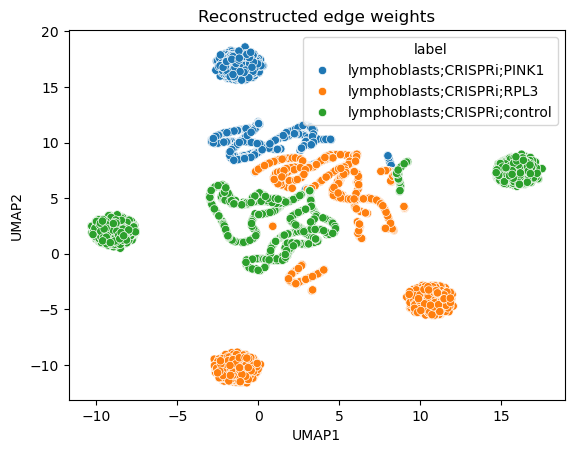

In [250]:
emb = edge_embeddings
pl_df = pd.concat([pd.DataFrame(emb, columns=['UMAP1','UMAP2']), label_map], axis=1)
# Plot the 2D UMAP representation
sns.scatterplot(pl_df, x='UMAP1', y='UMAP2', hue='label')
plt.title('Reconstructed edge weights')
plt.show()

In [ ]:
emb = original_edges
pl_df = pd.concat([pd.DataFrame(emb, columns=['UMAP1','UMAP2']), label_map], axis=1)
# Plot the 2D UMAP representation
sns.scatterplot(pl_df, x='UMAP1', y='UMAP2', hue='label')
plt.title('Original edge weights')
plt.show()

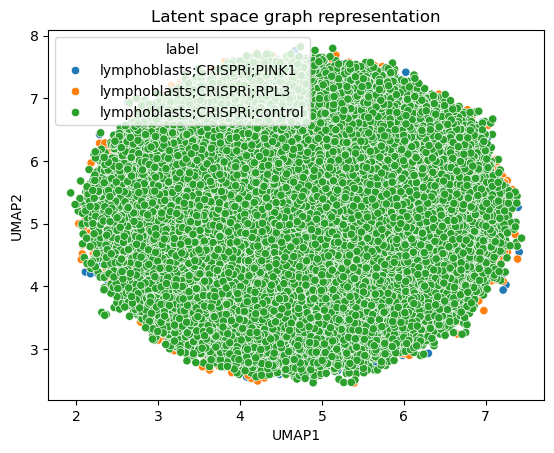

In [251]:
emb = latents
pl_df = pd.concat([pd.DataFrame(emb, columns=['UMAP1','UMAP2']), label_map], axis=1)
# Plot the 2D UMAP representation
sns.scatterplot(pl_df, x='UMAP1', y='UMAP2', hue='label')
plt.title('Latent space graph representation')
plt.show()

### 2. GRN Classifier

In [6]:
from src.models.grn_classifier import GRNDataset, GRNDataModule, GRNClassifierModule
# Create model
model = GRNClassifierModule(num_features, num_classes, **hp)

# Create callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(monitor='val_loss')
]

# Create trainer
trainer = pl.Trainer(
    max_epochs=max_epochs,
    callbacks=callbacks,
    accelerator='auto',
    devices=1
)

2024-12-04 16:45:56,011 - INFO - GPU available: True (cuda), used: True
2024-12-04 16:45:56,013 - INFO - TPU available: False, using: 0 TPU cores
2024-12-04 16:45:56,014 - INFO - HPU available: False, using: 0 HPUs


In [9]:
# Train model
trainer.fit(model, data_module)

2024-12-04 11:55:58,752 - INFO - You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-12-04 11:56:07.763562: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 11:56:09.228126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 11:56:09.344245: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 17808. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 15/15 [00:01<00:00, 14.45it/s, v_num=8.8e+6, train_loss=1.130, train_acc=0.385] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 15/15 [00:01<00:00, 12.83it/s, v_num=8.8e+6, train_loss=1.130, train_acc=0.385, val_loss=0.925, val_acc=0.333]

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 13356. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 1: 100%|██████████| 15/15 [00:00<00:00, 35.79it/s, v_num=8.8e+6, train_loss=0.955, train_acc=0.154, val_loss=0.925, val_acc=0.333]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 15/15 [00:00<00:00, 33.14it/s, v_num=8.8e+6, train_loss=0.693, train_acc=0.231, val_loss=0.759, val_acc=0.233]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 15/15 [00:00<00:00, 37.72it/s, v_num=8.8e+6, train_loss=0.737, train_acc=0.0769, val_loss=0.695, val_acc=0.333]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 15/15 [00:00<00:00, 36.55it/s, v_num=8.8e+6, train_loss=0.776, train_acc=0.154, val_loss=0.690, val_acc=0.333] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 15/15 [00:00<00:00, 30.04it/s, v_num=8.8e+6, train_loss=0.671, train_acc=0.231, val_loss=0.683, val_acc=0.333]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 15/15 [00:00<00:00, 35.94it/s, v_num=8.8e+6, train_loss=0

### 3. Graph Transformer Classifier

In [38]:
from src.models.GTC import GraphTransformerClassifier


gtc = GraphTransformerClassifier(
    num_node_features=num_features,
    num_classes=num_classes,
    learning_rate=1e-3,
    hidden_dim=128,
    num_layers=3,
    dropout=0.3,
    heads=4,
    pooling='concat'  # try 'max', 'mean', 'add' for different pooling strategies
)

# Create callbacks
callbacks = [
    # EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(monitor='val_acc')
]

# Create trainer
trainer = pl.Trainer(
    max_epochs=20,
    callbacks=callbacks,
    accelerator='auto',
    devices=1,
    # gradient_clip_val=1.0
)

2024-12-04 14:57:22,606 - INFO - GPU available: True (cuda), used: True
2024-12-04 14:57:22,607 - INFO - TPU available: False, using: 0 TPU cores
2024-12-04 14:57:22,608 - INFO - HPU available: False, using: 0 HPUs
